<a href="https://colab.research.google.com/github/Mikeoduoli/Data-Science-Repo/blob/main/Time_Series_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import Python libraries for the task
import pandas as pd
import warnings
import pytz
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from google.colab import files
from statsmodels.tsa.seasonal import seasonal_decompose
warnings.filterwarnings('ignore', category=FutureWarning)


#Let's look for the columns available in our dataset

In [56]:
df = pd.read_csv('/content/drive/MyDrive/craigslist_vehicles.csv', error_bad_lines=False, engine='python')

df.head(5);

In [57]:
#Display the column in my dataframe
df.columns

Index(['Unnamed: 0', 'id', 'url', 'region', 'region_url', 'price', 'year',
       'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'odometer',
       'title_status', 'transmission', 'VIN', 'drive', 'size', 'type',
       'paint_color', 'image_url', 'description', 'county', 'state', 'lat',
       'long', 'posting_date', 'removal_date'],
      dtype='object')

In [ ]:
#Some columns won't be needed, hence, list them in arrays of columns to dropped
columns_to_drop = ['Unnamed: 0', 'url', 'region_url', 'VIN', 'image_url', 'description', 'county', 'lat', 'long', 'removal_date'];

#A list comprehession for columns to be dropped.
columns_to_drop_existing = [col for col in columns_to_drop if col in df.columns];

#Now drop/delete the columns
data = df.drop(columns=columns_to_drop_existing)

#Convert posting_date column to date
data['posting_date'] = pd.to_datetime(data['posting_date'], utc=True);

#Display the data to see changes
data.head(5);

In [ ]:
#Let's see the data types of our columns
data.dtypes

id                            int64
region                       object
price                         int64
year                        float64
manufacturer                 object
model                        object
condition                    object
cylinders                    object
fuel                         object
odometer                    float64
title_status                 object
transmission                 object
drive                        object
size                         object
type                         object
paint_color                  object
state                        object
posting_date    datetime64[ns, UTC]
dtype: object

In [ ]:
#How many columns and rows
data.shape

(22554, 18)

In [ ]:
#Confirm missing values in the dataset
data.isnull().sum()

id                  0
region              0
price               0
year               19
manufacturer      833
model             292
condition        8279
cylinders        9214
fuel               73
odometer          151
title_status      666
transmission      141
drive            6739
size            16117
type             4229
paint_color      6257
state               0
posting_date        1
dtype: int64

Handling the missing values. You can use mode, mean to fill out the missing values.

In [ ]:
#Fill the missing numerical values with mean and categorical ones with mode
def handling_missing_values (data):
  #Filling numerical ones with mean
  numeric_columns = ['year', 'odometer']
  data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

  #Fill the categorical columns with mode
  categorical_columns = ['manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'title_status',
                           'transmission', 'drive', 'size', 'type', 'paint_color', 'posting_date'];
  data[categorical_columns] = data[categorical_columns].apply(lambda x: x.fillna(x.mode().iloc[0]))

  return data;

data = handling_missing_values(data);

In [ ]:
data.isnull().sum();

In [ ]:
#Display columns for the Cleaned data
data.columns

Index(['id', 'region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission',
       'drive', 'size', 'type', 'paint_color', 'state', 'posting_date'],
      dtype='object')

In [ ]:
#Also check data types after cleaning paying attention
data.dtypes

id                            int64
region                       object
price                         int64
year                        float64
manufacturer                 object
model                        object
condition                    object
cylinders                    object
fuel                         object
odometer                    float64
title_status                 object
transmission                 object
drive                        object
size                         object
type                         object
paint_color                  object
state                        object
posting_date    datetime64[ns, UTC]
dtype: object

What Next? Aggregate the data based on the "posting_date," "region," and "type" of vehicle, to be able to analyze the temporal patterns, seasonal trends, and demand-supply dynamics.

In [ ]:
from datetime import tzinfo
def convert_to_tz_aware (posting_date):
  if not posting_date.tzinfo:
    return posting_date.replace(tzinfo=pytz.utc)
  else:
    return posting_date

data['posting_date'] = data['posting_date'].apply(convert_to_tz_aware)

data_agg = data.groupby(['region', 'type', 'posting_date']).size().reset_index(name='count')

data_agg = data_agg.sort_values(by='posting_date')

data_agg.head()

,region,type,posting_date,count
392,albany,SUV,2021-04-04 00:00:00+00:00,9
2720,athens,other,2021-04-04 00:00:00+00:00,1
1749,ann arbor,truck,2021-04-04 00:00:00+00:00,1
2748,athens,pickup,2021-04-04 00:00:00+00:00,2
1718,ann arbor,sedan,2021-04-04 00:00:00+00:00,4


In [ ]:
#Data Visualization - Let's create a chart for interactive time-series
fig = px.line(data_agg, x = 'posting_date', y='count', color='region', line_group='type',
              title='Name of Available Vehicles Over Time by Region and Vehicle Type',
              labels = {'count' : 'Number of Vehicle'})

#Customize the layout
fig.update_layout(
    xaxis_title='Posting Data',
    yaxis_title ='Number of Vehicles',
    hovermode='x',
    showlegend = True,
)

#Display the chart
fig.show()

In [ ]:
#Let's now group the data by day and count the number listing
data_freq = data_agg.groupby(pd.Grouper(key = 'posting_date', freq='D')).sum().reset_index()

#Create a graph frequency for time
fig_freq = go.Figure(data=go.Bar(
    x = data_freq['posting_date'],
    y = data_freq['count'],
    marker_color = 'royalblue',
    opacity = 0.8
))


#Now Customize the layout - Renaming the x and y axis, and title for the chart
fig_freq.update_layout(
    title = 'Time Frequency Graph: Number of Vehicle Listings per Day',
    xaxis_title = 'Posting Date',
    yaxis_title = 'Number of Vehicle Listings',
    xaxis_tickangle = -45,
)

#Display the time frequency graph
fig_freq.show()



In [ ]:
#Performing Seasonal Decomposition
data_agg = data_freq.set_index('posting_date')
result = seasonal_decompose(data_agg['count'], model='additive', period = 12)

#Dataframe to store decomposed components
decomposed_data = pd.DataFrame({
    'trend' : result.trend,
    'seasonal' : result.seasonal,
    'residual' : result.resid,
})

#Reset the index for decomposed data
decomposed_data = decomposed_data.reset_index()

#Now plot the decomposed data
fig_decompose = go.Figure()

fig_decompose.add_trace(go.scatter(x = decomposed_data['posting_date'], y = decomposed_data['trend'],
                                   mode = 'lines', name = 'Trend'))

fig_decompose.add_trace(go.scatter(x = decomposed_data['posting_date'], y = decomposed_data['seasonal'],
                                   mode = 'lines', name = 'Seasonal'))

fig_decompose.add_trace(go.scatter(x = decomposed_data['posting_date'], y = decomposed_data['residual'],
                                   mode = 'lines', name = 'Residual'))

#Customize the layout/Renaming axes and the title
fig_decompose.update_layout(
    title = 'Seasonal Decompostion of Time Series',
    xaxis_title = 'Posting Date',
    yaxis_title = 'Counts',
    showlegend = True
)

fig_decompose.show()

#Requires more data - the data provided is insufficient to perform the intended analysis

TypeError: ignored

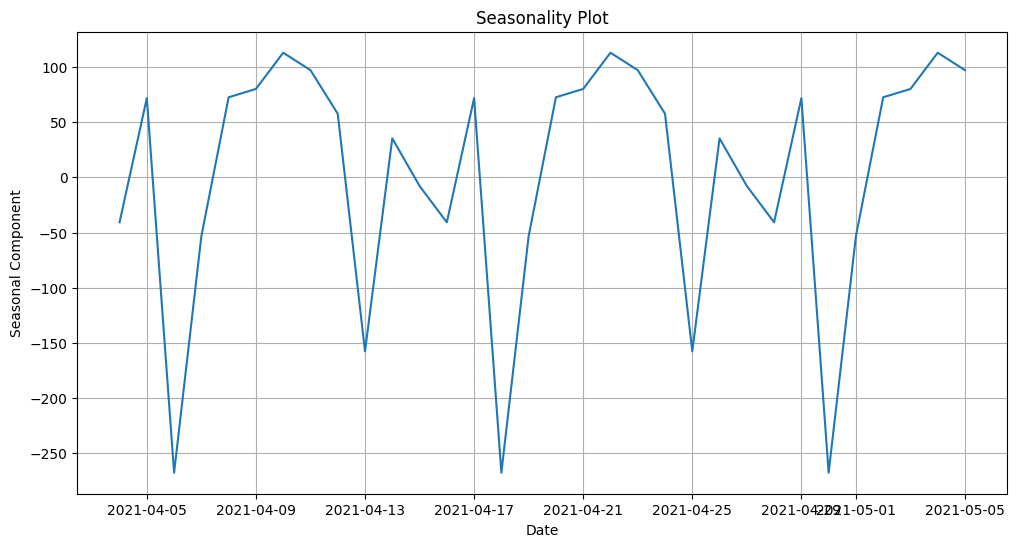

In [ ]:
#Convert 'posting_date' to Datetime data type
data['posting_date'] = pd.to_datetime(data['posting_date'], utc = True)

#Extract date from 'posting_date' column for aggregation
data['date'] = data['posting_date'].dt.date

#Performing aggregation based on region and date
data_agg = data.groupby(['region', 'date']).size().reset_index(name='count')

#Creating a pivot table to handle missing data
data_pivot = data_agg.pivot(index = 'date', columns = 'region', values = 'count')

#Perform Seasonal Decomposition
seasonal_decomposition = seasonal_decompose(data_pivot.sum(axis = 1), model = 'additive', period = 12)

#Plot Seasonality Components
plt.figure(figsize=(12, 6))
plt.plot(seasonal_decomposition.seasonal.index, seasonal_decomposition.seasonal.values)
plt.xlabel('Date');
plt.ylabel('Seasonal Component')
plt.title('Seasonality Plot')
plt.grid(True)
plt.show()